In [13]:
# neural_ode_diffrax.py
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import diffrax
from functools import partial

In [14]:
# Enable 64-bit precision
# jax.config.update("jax_enable_x64", True)

In [15]:
class NeuralODEDiffrax:
    def __init__(self, hidden_dim=64, learning_rate=1e-3):
        """
        Neural ODE using Diffrax for ODE solving with adaptive step sizes
        """
        self.hidden_dim = hidden_dim
        
        # Initialize network parameters
        key = jax.random.PRNGKey(42)
        key1, key2, key3 = jax.random.split(key, 3)
        
        self.params = {
            'w1': jax.random.normal(key1, (2, hidden_dim)) * 0.1,
            'b1': jax.random.normal(key2, (hidden_dim,)) * 0.1,
            'w2': jax.random.normal(key3, (hidden_dim, 1)) * 0.1,
            'b2': jnp.zeros((1,))
        }
        
        self.optimizer = optax.adam(learning_rate)
        self.opt_state = self.optimizer.init(self.params)
    
    def dynamics_fn(self, t, y, args):
        """
        ODE dynamics function for Diffrax: dy/dt = f(t, y)
        
        Note: Diffrax expects signature f(t, y, args) unlike our previous f(y, t)
        """
        params = args
        # Combine y and t into input features
        inputs = jnp.array([y, t])
        
        # Forward pass through the network
        hidden = jnp.tanh(jnp.dot(inputs, params['w1']) + params['b1'])
        output = jnp.dot(hidden, params['w2']) + params['b2']
        
        return output[0]  # Return scalar
    
    def solve_ode(self, params, y0, t_eval):
        """
        Solve ODE using Diffrax's Tsit5 solver (5th order Runge-Kutta method)
        
        Tsit5 is an adaptive step-size solver that's more accurate than Euler
        """
        # Define the ODE problem
        term = diffrax.ODETerm(self.dynamics_fn)
        
        # Create solver with adaptive step size control
        solver = diffrax.Tsit5()
        
        # Define saving times - when to output the solution
        saveat = diffrax.SaveAt(ts=t_eval)
        
        # Define step size controller
        stepsize_controller = diffrax.PIDController(rtol=1e-5, atol=1e-7)
        
        # Solve the ODE
        solution = diffrax.diffeqsolve(
            term,
            solver,
            t0=t_eval[0],      # Initial time
            t1=t_eval[-1],     # Final time
            dt0=0.1,           # Initial step size
            y0=y0,             # Initial state
            args=params,       # Parameters for dynamics function
            saveat=saveat,
            stepsize_controller=stepsize_controller,
            max_steps=10000    # Maximum number of steps
        )
        
        return solution.ys
    
    @partial(jax.jit, static_argnums=(0,))
    def loss_fn(self, params, y0, t_eval, y_true):
        """
        Compute mean squared error using Diffrax solver
        """
        y_pred = self.solve_ode(params, y0, t_eval)
        return jnp.mean((y_pred - y_true) ** 2)
    
    @partial(jax.jit, static_argnums=(0,))
    def update_step(self, params, opt_state, y0, t_eval, y_true):
        """
        Single training step with Diffrax
        """
        # Compute loss and gradients
        loss, grads = jax.value_and_grad(self.loss_fn)(params, y0, t_eval, y_true)
        
        # Update parameters
        updates, new_opt_state = self.optimizer.update(grads, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        
        return new_params, new_opt_state, loss

In [16]:
def generate_synthetic_data(t_eval):
    """Generate true trajectory: y(t) = sin(t)"""
    return jnp.sin(t_eval)

In [17]:
def train_and_visualize():
    # Create time points for evaluation
    t_eval = jnp.linspace(0, 2 * jnp.pi, 100)
    
    # Generate true data
    y_true = generate_synthetic_data(t_eval)
    y0 = y_true[0]  # Initial condition
    
    # Initialize Neural ODE with Diffrax
    node = NeuralODEDiffrax(hidden_dim=64, learning_rate=1e-2)
    
    # Training loop
    num_epochs = 2000
    print_interval = 100
    
    trajectories = []
    losses = []
    
    print("Training Neural ODE with Diffrax...")
    for epoch in range(num_epochs):
        # Training step
        node.params, node.opt_state, loss = node.update_step(
            node.params, node.opt_state, y0, t_eval, y_true
        )
        
        losses.append(loss)
        
        if epoch % print_interval == 0:
            # Store trajectory for visualization
            y_pred = node.solve_ode(node.params, y0, t_eval)
            trajectories.append((epoch, y_pred))
            print(f"Epoch {epoch}, Loss: {loss:.6f}")
    
    # Final prediction
    y_pred_final = node.solve_ode(node.params, y0, t_eval)
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Final prediction vs true data
    plt.subplot(1, 3, 1)
    plt.plot(t_eval, y_true, 'b-', label='True: sin(t)', linewidth=2)
    plt.plot(t_eval, y_pred_final, 'r--', label='Predicted (Diffrax)', linewidth=2)
    plt.xlabel('Time t')
    plt.ylabel('y(t)')
    plt.title('Final Prediction - Diffrax')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Training loss
    plt.subplot(1, 3, 2)
    plt.plot(losses)
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.title('Training Loss - Diffrax')
    plt.grid(True)
    
    # Plot 3: Learning progression
    plt.subplot(1, 3, 3)
    plt.plot(t_eval, y_true, 'b-', label='True', linewidth=3)
    for i, (epoch, traj) in enumerate(trajectories):
        alpha = 0.3 + 0.7 * (i / len(trajectories))
        plt.plot(t_eval, traj, 'r--', alpha=alpha, label=f'Epoch {epoch}' if i % 2 == 0 else "")
    plt.xlabel('Time t')
    plt.ylabel('y(t)')
    plt.title('Learning Progression - Diffrax')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('neural_ode_diffrax.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return node, t_eval, y_true, y_pred_final

Training Neural ODE with Diffrax...
Epoch 0, Loss: 0.622499
Epoch 100, Loss: 0.126641
Epoch 200, Loss: 0.043091
Epoch 300, Loss: 0.028781
Epoch 400, Loss: 0.015078
Epoch 500, Loss: 0.019543
Epoch 600, Loss: 0.010117
Epoch 700, Loss: 0.016888
Epoch 800, Loss: 0.007552
Epoch 900, Loss: 0.013012
Epoch 1000, Loss: 0.004832
Epoch 1100, Loss: 0.010648
Epoch 1200, Loss: 0.004467
Epoch 1300, Loss: 0.021976
Epoch 1400, Loss: 0.007054
Epoch 1500, Loss: 0.003616
Epoch 1600, Loss: 0.019835
Epoch 1700, Loss: 0.004786
Epoch 1800, Loss: 0.002227
Epoch 1900, Loss: 0.003509


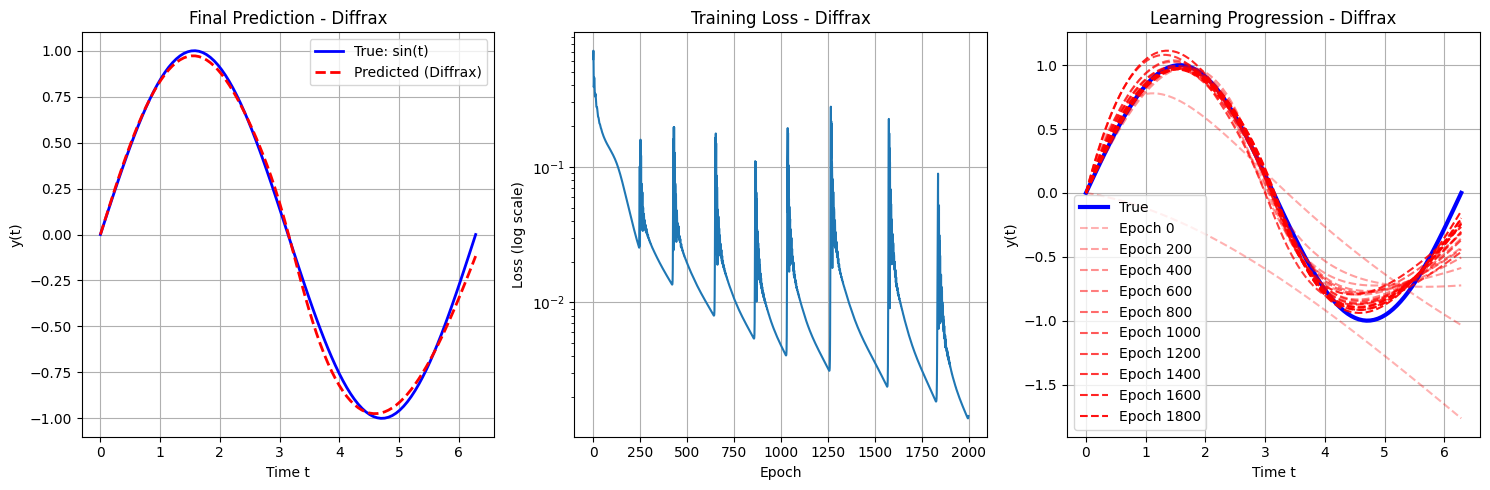

In [18]:
if __name__ == "__main__":
    model, t_eval, y_true, y_pred = train_and_visualize()